# L44 Tweet Emotion Classification Project

In [5]:
# Import everything that will be used
from keras.models import Sequential
from keras.layers import *
from keras.regularizers import l2
from keras.preprocessing.sequence import pad_sequences
import gensim
import sys
import numpy as np
import pandas as pd
import string
import logging
import random
import matplotlib.pyplot as plt

In [23]:
SELECTED_DATA = "ssec"
SELECTED_VECTOR_TYPES = ["fasttext", "affectvec"]
VECTOR_FILENAMES = {"word2vec" : "vectors/word2vec/GoogleNews-vectors-negative300.bin",
                    "affectvec" : "vectors/AffectVec-v1.0-vectors/AffectVec-data.txt",
                    "fasttext" : "vectors/fasttext/wiki-news-300d-1M.vec"}

## Load Raw Data

Load datasets used for training and testing.

In [25]:
# Prepare data
if SELECTED_DATA == "crowdflower":
    crowdflower_filename = "data/crowdflower.csv"
    df = pd.read_csv(crowdflower_filename)
    df.rename(columns={'sentiment':'emotion', 'content':'tweet'}, inplace=True)
    df['tweet'] = df['tweet'].map(lambda tweet : list(gensim.utils.simple_preprocess(tweet)))
    del df['tweet_id']
    del df['author']
    # Delete tweets labelled with emotions that occur less than 1000 times
    emotions, ccount = np.unique(df.emotion, return_counts=True)
    for emotion, count in zip(emotions, ccount):
        if count < 1500:
            df.drop(df[df['emotion'] == emotion].index, inplace=True)
elif SELECTED_DATA  == "tec":
    tec_filename = "data/Jan9-2012-tweets-clean.txt"
    with open(tec_filename, 'r') as tec_file:
        lines = []
        for line in tec_file:
            components = line.split('::')
            tweet = '::'.join(components[:-1])[20:].strip()
            tweet = list(gensim.utils.simple_preprocess(tweet))
            emotion = components[-1].strip()
            lines.append([tweet, emotion])
    df = pd.DataFrame(lines, columns=["tweet", "emotion"])
elif SELECTED_DATA == "ssec":
    ssec_test_filename = "data/ssec-aggregated/test-combined-0.0.csv"
    ssec_train_filename = "data/ssec-aggregated/train-combined-0.0.csv"
    def get_df(filename):
        with open(filename, 'r') as file:
            lines = []
            for line in file:
                components = line.split('\t')
                tweet = list(gensim.utils.simple_preprocess("\t".join(components[8:])))
                emotions = [c for c in components[:8] if c != "---"]
                # Don't include tweets with no labelled emotion
                if emotions != []:
                    lines.append([tweet, emotions])
            return pd.DataFrame(lines, columns=["tweet", "emotion"])
    df_test = get_df(ssec_test_filename)
    df_train = get_df(ssec_train_filename)
    df = df_test.append(df_train)
print(df)

                                                  tweet  \
0     [he, who, exalts, himself, shall, be, humbled,...   
1     [rt, prayerbullets, remove, nehushtan, previou...   
2     [brainman, heidtjj, benjaminlives, have, sough...   
3     [god, is, utterly, powerless, without, human, ...   
4     [david_cameron, miracles, of, miracles, of, sh...   
...                                                 ...   
2867  [there, law, protecting, unborn, eagles, but, ...   
2868           [am, in, have, had, an, abortion, semst]   
2869  [how, dare, you, say, my, sexual, preference, ...   
2870  [equal, rights, for, those, born, that, way, n...   
2871  [potus, seals, his, legacy, doz, wins, the, go...   

                                                emotion  
0            [Anger, Anticipation, Disgust, Joy, Trust]  
1                                 [Joy, Sadness, Trust]  
2                            [Anticipation, Joy, Trust]  
3                  [Anticipation, Fear, Sadness, Trust]  
4

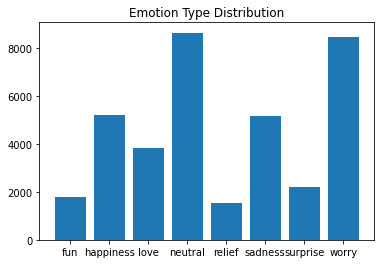

Emotion mapping: {'relief': 0, 'surprise': 1, 'happiness': 2, 'love': 3, 'sadness': 4, 'worry': 5, 'fun': 6, 'neutral': 7}


In [14]:
# Visualise emotion counts
if SELECTED_DATA == "ssec":
    emotions = ["Anger", "Anticipation", "Disgust", "Fear", "Joy", "Sadness", "Surprise", "Trust"]
    ccount = [len(df[df['emotion'].map(lambda r : emotion in r)]) for emotion in emotions]
else:
    emotions, ccount = np.unique(df.emotion, return_counts=True)
plt.figure()
plt.title("Emotion Type Distribution")
plt.bar(emotions, ccount, align='center')
plt.show()

# Get number of emotions and create a map
n_emotions = len(emotions)
emotion_dict = {e : i for i, e in enumerate(set(emotions))}
print("Emotion mapping: {}".format(emotion_dict))

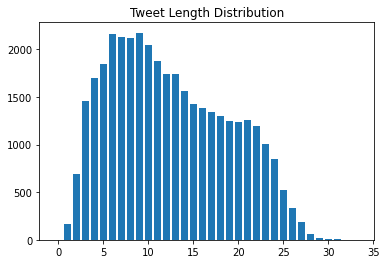

Maximum tweet length: 33


In [15]:
# Visualise tweet lengths
tweet_lengths = df.tweet.map(lambda t: len(t))
lengths, ccount = np.unique(tweet_lengths, return_counts=True)
plt.figure()
plt.title("Tweet Length Distribution")
plt.bar(lengths, ccount, align='center')
plt.show()

max_length = max(lengths)
print("Maximum tweet length: {}".format(max_length))

## Word Embedding Preparation
Load pre-trained word embedding models.

In [16]:
# Load word embedding vectors and append together if more than one selected
embedding_weights = None
main_model = None
vocab_size, embedding_size = 0, 0
for vector_type in SELECTED_VECTOR_TYPES:
    vec_filename = VECTOR_FILENAMES[vector_type]
    vec_model = gensim.models.KeyedVectors.load_word2vec_format(vec_filename, binary=("bin" in vec_filename))
    vec_weights = vec_model.vectors
    if main_model is None:
        main_model = vec_model
        vocab_size, embedding_size = vec_weights.shape 
    if embedding_weights is None:
        embedding_weights = vec_weights
        print("Created embedding vectors of length {} from: {}".format(embedding_size, vec_filename))
    else:
        # For additional vector sets, append each word vector (or pad with 0s) to each previous word vector
        num_vecs, vec_length = vec_weights.shape
        vec_weights = np.append(vec_weights, np.zeros((1, vec_length)), 0)
        append_indices = []
        for i in range(vocab_size):
            word = main_model.index_to_key[i]
            if word in vec_model:
                append_indices.append(vec_model.key_to_index[word])
            else:
                append_indices.append(num_vecs) # index to zero-vector
        append_weights = vec_weights[np.array(append_indices)]
        embedding_weights = np.append(embedding_weights, append_weights, 1)
        embedding_size += vec_length
        del vec_weights
        del vec_model
        print("Appended embedding vectors of length {} from: {}".format(vec_length, vec_filename))
print("Vocabulary Size: {} - Embedding Dim: {}".format(vocab_size, embedding_size))

Created embedding vectors of length 300 from: vectors/fasttext/wiki-news-300d-1M.vec
Appended embedding vectors of length 239 from: vectors/AffectVec-v1.0-vectors/AffectVec-data.txt
Vocabulary Size: 999994 - Embedding Dim: 539


## Data Preparation
Convert tweets into token IDs for the embedding layer of the LSTM and prepare datasets for training, validation and testing.

In [17]:
# Convert tweets to token IDs
def get_data_from_df(dataframe):
    set_x = []
    set_y = []

    for tweet, emotion in zip(dataframe.tweet, dataframe.emotion):
        words = np.array([main_model.key_to_index[word] if word in main_model else 0 for word in tweet])
        set_x.append(words)
        if SELECTED_DATA == "ssec":
            set_y.append([1 if k in emotion else 0 for k in emotion_dict])
        else:
            set_y.append(emotion_dict[emotion])

    set_x = pad_sequences(set_x, maxlen=max_length, padding='pre', value=0)
    set_y = np.array(set_y)

    return set_x, set_y

In [18]:
VALID_PER = 0.1
TEST_PER = 0.1

random.seed(1)

# Shuffle and split the data
if SELECTED_DATA == "ssec":
    set_x, set_y = get_data_from_df(df_train)
    test_x, test_y = get_data_from_df(df_test)
    total_samples = set_x.shape[0]
    n_val = int(VALID_PER * total_samples)
    n_train = total_samples - n_val

    random_i = random.sample(range(total_samples), total_samples)
    train_x = set_x[random_i[:n_train]]
    train_y = set_y[random_i[:n_train]]
    val_x = set_x[random_i[n_train:n_train+n_val]]
    val_y = set_y[random_i[n_train:n_train+n_val]]
    print(val_y)

else:
    set_x, set_y = get_data_from_df(df)
    total_samples = set_x.shape[0]
    n_test = int(TEST_PER * total_samples)
    n_val = int(VALID_PER * total_samples)
    n_train = total_samples - n_test - n_val

    random_i = random.sample(range(total_samples), total_samples)
    train_x = set_x[random_i[:n_train]]
    train_y = set_y[random_i[:n_train]]
    val_x = set_x[random_i[n_train:n_train+n_val]]
    val_y = set_y[random_i[n_train:n_train+n_val]]
    test_x = set_x[random_i[n_train+n_val:n_train+n_val+n_test]]
    test_y = set_y[random_i[n_train+n_val:n_train+n_val+n_test]]

print("Train Shapes - X: {} - Y: {}".format(train_x.shape, train_y.shape))
print("Val Shapes - X: {} - Y: {}".format(val_x.shape, val_y.shape))
print("Test Shapes - X: {} - Y: {}".format(test_x.shape, test_y.shape))

Train Shapes - X: (29442, 33) - Y: (29442,)
Val Shapes - X: (3680, 33) - Y: (3680,)
Test Shapes - X: (3680, 33) - Y: (3680,)


## Defining LSTM Model

In [19]:
model = Sequential()

# Keras Embedding layer with Word2Vec weights initialization
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_size,
                    weights=[embedding_weights],
                    input_length=max_length,
                    mask_zero=True,
                    trainable=False))

model.add(Bidirectional(LSTM(150, dropout = 0.5, recurrent_dropout = 0.5)))
model.add(Dense(50, activation='relu'))
if SELECTED_DATA == "ssec":
    model.add(Dense(n_emotions, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
else:
    model.add(Dense(n_emotions, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 33, 539)           538996766 
_________________________________________________________________
bidirectional (Bidirectional (None, 300)               828000    
_________________________________________________________________
dense (Dense)                (None, 50)                15050     
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 408       
Total params: 539,840,224
Trainable params: 843,458
Non-trainable params: 538,996,766
_________________________________________________________________


In [20]:
    # Fit model
    train_history = model.fit(train_x, train_y, epochs=4, batch_size=max_length, validation_data=(val_x, val_y), verbose=1)

Epoch 1/4
893/893 [==============================] - 281s 308ms/step - loss: 1.7721 - accuracy: 0.3295 - val_loss: 1.6518 - val_accuracy: 0.3842
Epoch 2/4
893/893 [==============================] - 344s 385ms/step - loss: 1.6424 - accuracy: 0.3882 - val_loss: 1.6179 - val_accuracy: 0.3962
Epoch 3/4
893/893 [==============================] - 305s 341ms/step - loss: 1.6033 - accuracy: 0.4089 - val_loss: 1.6117 - val_accuracy: 0.4068
Epoch 4/4
893/893 [==============================] - 272s 305ms/step - loss: 1.5818 - accuracy: 0.4133 - val_loss: 1.5965 - val_accuracy: 0.4122


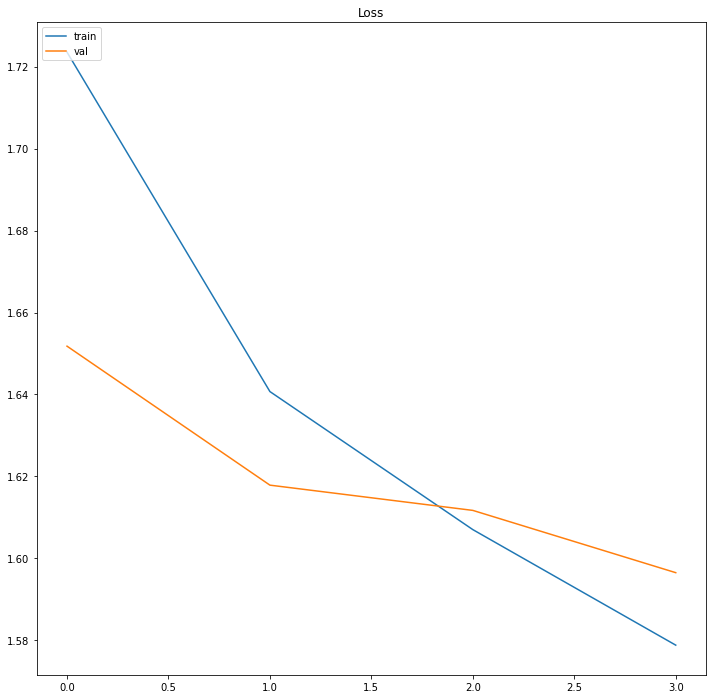

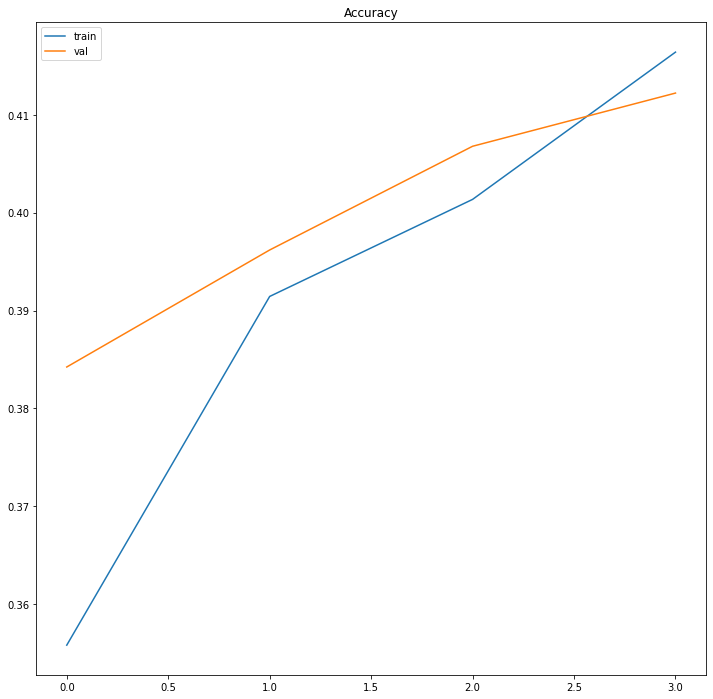

In [21]:
# Plotting Loss and Accuracy Graphs
plt.figure(figsize=(12, 12))
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.title('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(12, 12))
plt.plot(train_history.history['accuracy'])
plt.plot(train_history.history['val_accuracy'])
plt.title('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [22]:
from sklearn.metrics import precision_score, recall_score, f1_score

preds = model.predict(val_x)
if SELECTED_DATA == "ssec":
    preds[preds>=0.5] = 1
    preds[preds<0.5] = 0
else:
    preds = np.argmax(preds, axis=1)
scores = []
total_tp, total_pred, total_gold = 0, 0, 0
emotions = list(emotion_dict)
list.sort(emotions)
for emotion in emotions:
    if SELECTED_DATA == "ssec":
        preds_emotion = preds[:,emotion_dict[emotion]]
        true_emotion = val_y[:,emotion_dict[emotion]]
        total_pred += sum(preds_emotion)
        total_gold += sum(true_emotion)
        total_tp += sum(preds_emotion + true_emotion == 2)
        prec = precision_score(preds_emotion, true_emotion)
        rec = recall_score(preds_emotion, true_emotion)
        f1 = f1_score(preds_emotion, true_emotion)
    else:
        prec = precision_score(preds, val_y, labels=[emotion_dict[emotion]], average=None, zero_division=0)
        rec = recall_score(preds, val_y, labels=[emotion_dict[emotion]], average=None, zero_division=0)
        f1 = f1_score(preds, val_y, labels=[emotion_dict[emotion]], average=None, zero_division=0)
    scores.append([emotion, prec, rec, f1])
if SELECTED_DATA == "ssec":
    micro_prec = total_tp / total_pred
    micro_rec = total_tp / total_gold
    micro_f1 = (2 * micro_prec * micro_rec) / (micro_prec + micro_rec)
else:
    micro_prec = precision_score(preds, val_y, average='micro', zero_division=0)
    micro_rec = recall_score(preds, val_y, average='micro', zero_division=0)
    micro_f1 = f1_score(preds, val_y, average='micro', zero_division=0)
scores.append(["micro", micro_prec, micro_rec, micro_f1])
print(pd.DataFrame(scores, columns=["Emotion", "Precision", "Recall", "F-Score"]))


     Emotion                Precision                 Recall  \
0        fun    [0.02185792349726776]   [0.3076923076923077]   
1  happiness     [0.4806201550387597]  [0.35942028985507246]   
2       love     [0.4329896907216495]   [0.5153374233128835]   
3    neutral     [0.5292096219931272]  [0.45517241379310347]   
4     relief  [0.0072992700729927005]                 [0.25]   
5    sadness     [0.2982456140350877]   [0.3768472906403941]   
6   surprise     [0.0228310502283105]                  [0.5]   
7      worry     [0.5593419506462984]  [0.39144736842105265]   
8      micro                 0.412228               0.412228   

                  F-Score  
0   [0.04081632653061224]  
1    [0.4112769485903815]  
2    [0.4705882352941177]  
3     [0.489406779661017]  
4  [0.014184397163120567]  
5   [0.33297062023939067]  
6   [0.04366812227074236]  
7    [0.4605708756652153]  
8                0.412228  
